<a href="https://colab.research.google.com/github/madhumakireddy/WebGLSamples.github.io/blob/master/Copy_of_CS666_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

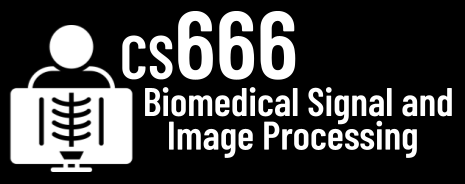
# Assignment 6

In [ ]:
# NAME:madhu sudahan reddy makireddy

In [66]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [67]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [68]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [69]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-24 04:49:14--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz.1’

mito.npz.1          100%[===================>]  35.87M  --.-KB/s    in 0.1s    

2023-04-24 04:49:17 (282 MB/s) - ‘mito.npz.1’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [71]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

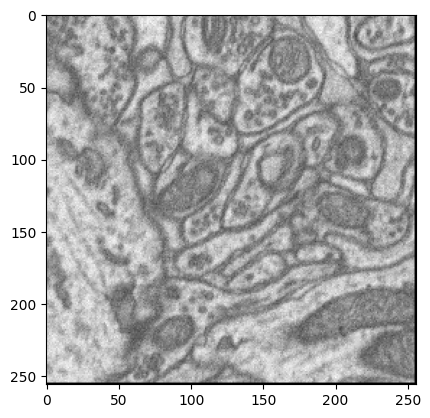

In [72]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE
import matplotlib.pyplot as plt

# Assuming that the 'images' array has been loaded as described in the previous code snippet.
first_image = images[0]

# Display the first image with gray colormap.
plt.imshow(first_image, cmap='gray')
plt.show()


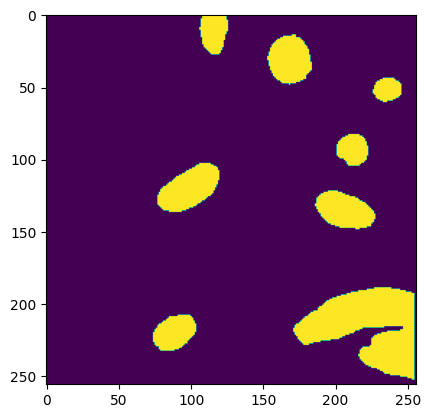

In [73]:
# TODO: Show the first mask.
import matplotlib.pyplot as plt

# Assuming that the 'masks' array has been loaded as described in the previous code snippet.
first_mask = masks[0]

# Display the first mask.
plt.imshow(first_mask)
plt.show()


## 1. SAM in AUTO mode (15 points)

In [74]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [76]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [77]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


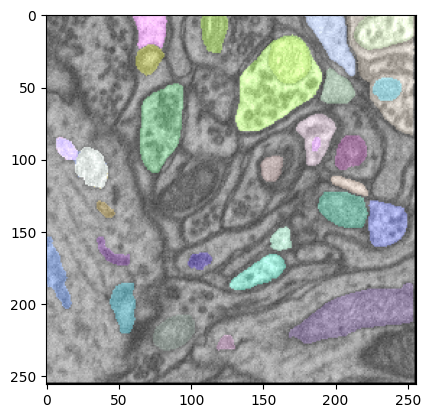

In [78]:
imshow( mh.imread('first_output.png') )

In [79]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: YOUR_ANSWER

SAM is a general-purpose segmentation technique that can be used for mitochondria detection, although the size, shape, and intensity distribution of the mitochondria as well as the selection of sample parameters can have an impact on the accuracy of the approach. The segmentation results may require manual annotation or post-processing even though SAM is totally automatic and can be helpful for large-scale applications.

In [80]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

vit_l model already exists as 'vit_l.pth'. Skipping download.


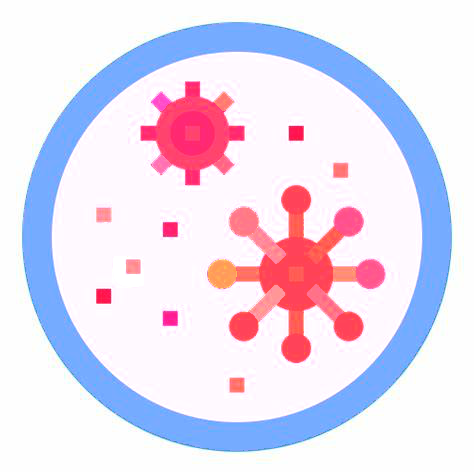

In [81]:


from metaseg import SegAutoMaskPredictor
import mahotas as mh
from google.colab.patches import cv2_imshow

# Replace 'your_image.png' with the filename of your image.
image_path = 'run.png'

# Run SAM in auto mode on the input image and save the result as 'second_output.png'.
results = SegAutoMaskPredictor().image_predict(
    source=image_path,
    model_type="vit_l",
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="second_output.png",
    show=False,
    save=True,
)

# Display the output image.
output_image = mh.imread('second_output.png')
cv2_imshow(output_image)


In [82]:
# TODO: Does SAM work well on your example?
# TODO: YOUR_ANSWER
#yes it works well on my example

## 2. Train a U-Net classifier from scratch (50 points)


In [83]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

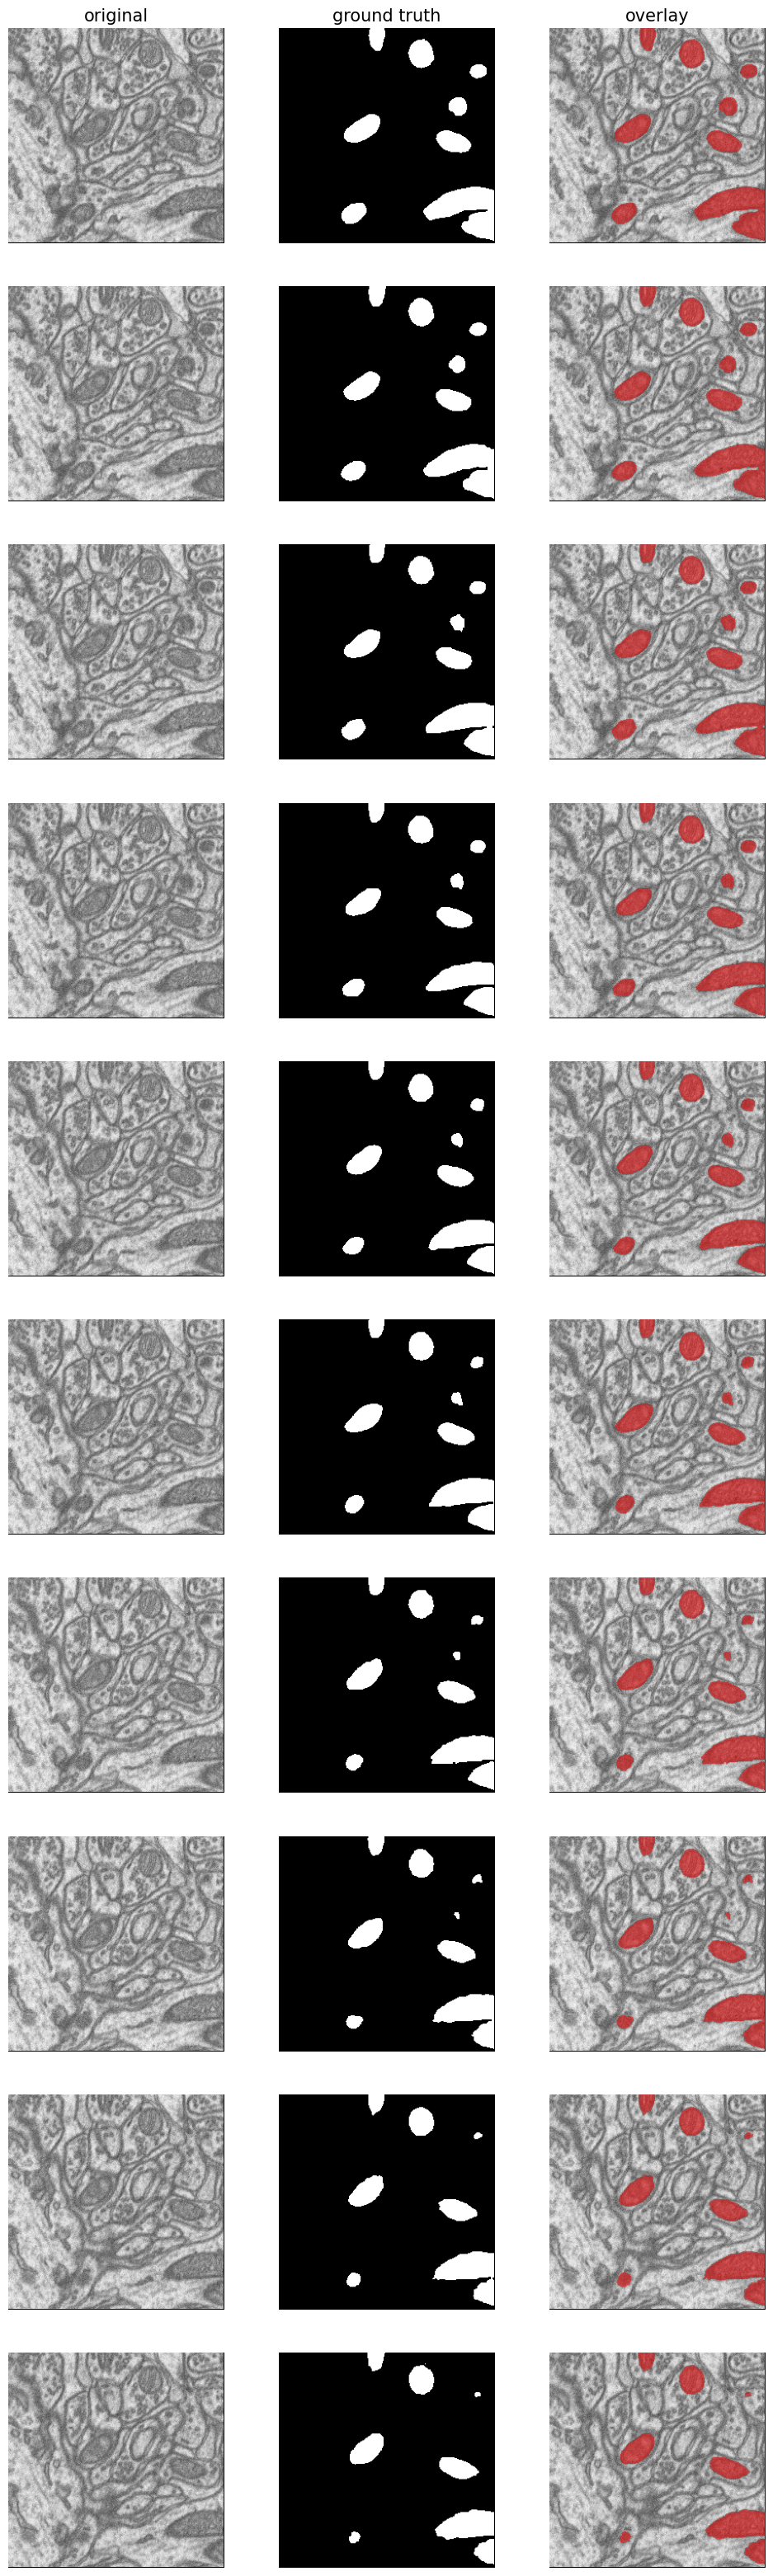

In [85]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [86]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [87]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
import numpy as np

# Convert to float32
X = images.astype(np.float32)

# Normalize to the range of 0..1
X /= np.max(X)

# Add the last channel using .reshape
X = X.reshape((660, 256, 256, 1))

# Print the shape and data type of X
print(X.shape, X.dtype)


(660, 256, 256, 1) float32


In [88]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [89]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [90]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# Convert to bool
y = masks.astype(np.bool)

# Add the last channel using .reshape
y = y.reshape((660, 256, 256, 1))



<ipython-input-90-c4015e2d12f2>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = masks.astype(np.bool)


In [91]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [92]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [94]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [95]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [96]:
# TODO: Why do we call train_test_split twice?
# TODO: YOUR_ANSWER

We call train_test_split twice to create three different sets, namely train, validation and test, from the original dataset. The first call splits the data into a training set and a test set, and the second call splits the training set into a new training set and a validation set. This is done in order to have independent sets for training, tuning hyperparameters, and testing the final model, respectively.

In [97]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [98]:
# TODO: Please explain the code from above.
# TODO: YOUR_ANSWER

The code above creates a data generator with data augmentation using the get_augmented function from keras_unet.utils. The training data X_train and y_train, along with batch size and data augmentation parameters, are passed to the get_augmented function. Rotation, shifting, shearing, zooming, horizontal and vertical flipping, and fill mode are some of the data augmentation parameters. Batches of enhanced training data are returned by the data generator and used to train the U-Net model.

(2, 256, 256, 1) (2, 256, 256, 1)


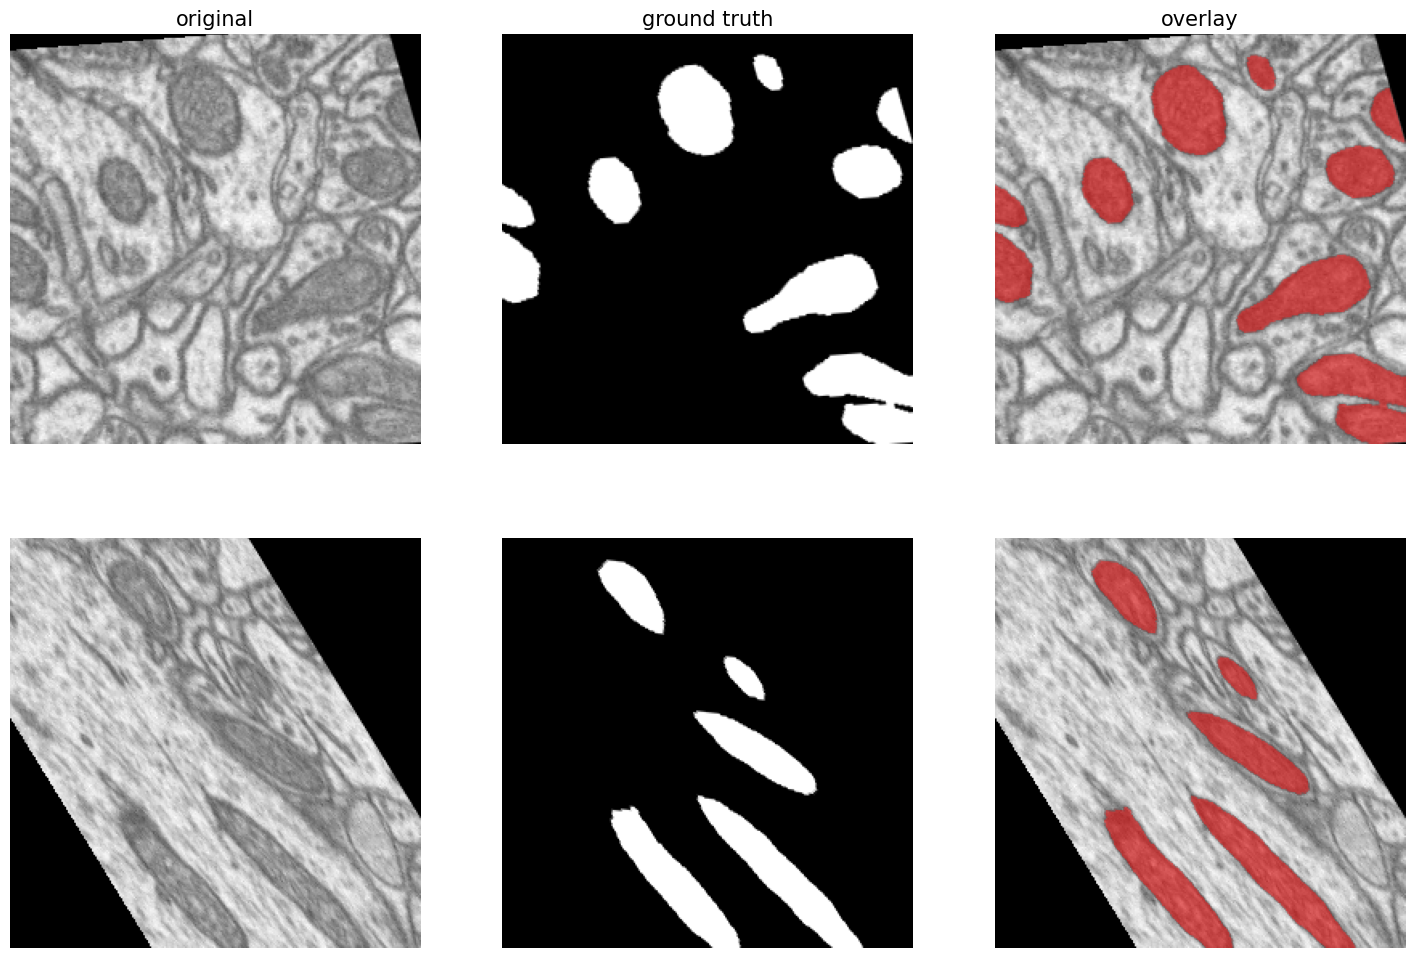

In [99]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [100]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [101]:
# TODO: How many  trainable parameters does the model use?
# TODO: YOUR_ANSWER
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d_10 (SpatialD  (None, 256, 256, 64  0          ['conv2d_38[0][0]']              
 ropout2D)                      )                                                           

In [102]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [103]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [104]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: YOUR_ANSWER

Intersection-over-Union (IoU) is a metric used for evaluating the similarity between two sets of data, often used in object detection and segmentation tasks. It is the ratio of the intersection of two sets to the union of the two sets, i.e., the overlapping area divided by the combined area of the two sets. A high IoU score indicates good overlap between the predicted and ground truth masks.

In [ ]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // 2,
    epochs=30,
    validation_data=(X_val, y_val),
    verbose=1
)
    


Epoch 1/30
184/184 [==============================] - 34s 174ms/step - loss: 0.2478 - iou: 0.0445 - iou_thresholded: 2.6853e-04 - val_loss: 0.2551 - val_iou: 0.0704 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
184/184 [==============================] - 31s 168ms/step - loss: 0.1822 - iou: 0.1072 - iou_thresholded: 6.9676e-04 - val_loss: 0.1741 - val_iou: 0.1592 - val_iou_thresholded: 8.5874e-06
Epoch 3/30
184/184 [==============================] - 30s 163ms/step - loss: 0.1732 - iou: 0.1262 - iou_thresholded: 0.0045 - val_loss: 0.2002 - val_iou: 0.1111 - val_iou_thresholded: 6.0699e-06
Epoch 4/30
170/184 [==========================>...] - ETA: 2s - loss: 0.1846 - iou: 0.1045 - iou_thresholded: 1.7478e-04

In [ ]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [ ]:
# TODO: Do these plots look good to you?
# TODO: YOUR_ANSWER
#yes

## 3. Evaluate U-Net (10 points)

In [ ]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

In [ ]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [ ]:
import sklearn.metrics

In [ ]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

In [ ]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: YOUR_ANSWER 

Jaccard score and Intersect-over-Union (IoU) are both measures of the similarity between two sets of data. However, the main difference is in how they compute overlap between the two sets. Jaccard score measures the size of the intersection divided by the size of the union, while IoU measures the size of the intersection divided by the size of the union minus the size of the intersection. In other words, Jaccard score considers all points in the sets equally, while IoU weighs the intersection more heavily than the union.

In [ ]:
# TODO: Did the U-Net perform well on X_test?
# TODO: YOUR_ANSWER

Based on the Jaccard score of 0.83, it seems that the U-Net performed relatively well on the X_test dataset. However, it's difficult to make a definitive conclusion about the performance of the model without more information about the task at hand and the specific requirements for a successful classification.

## 4. Combine U-Net with SAM (10 points)

In [ ]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [ ]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [ ]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [ ]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [ ]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [ ]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  #The code below saves an image called "test.png". The image is created from the first channel of the "img" array, which is multiplied by 255 and converted to an unsigned integer 8-bit format. 
  #The resulting image is saved using the mahotas package's "imsave" function.
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  #This code threshold the predicted mask at 0.5 probability value, which means all the pixel values in the predicted mask which are greater than 0.5 will be considered as positive and less than 0.5 will be considered as negative. 
  #This step is necessary for the binary classification problem, 
  #where we have to classify pixels into two categories, foreground and background.
  pred = (y_pred[z] > 0.5)

  # TODO: EXPLAIN CODE BELOW
  #The code above applies a threshold of 0.5 to the predicted segmentation output y_pred for a single slice z. 
  #It then labels the connected components of the resulting binary mask using Mahotas' labeled.label function, and returns the labeled mask and the number of connected components.
  pred, _ = mh.labeled.label(pred)

  
  # TODO: EXPLAIN CODE BELOW
  #This code extracts the bounding box coordinates for all connected components in the binary mask pred. 
  #The bounding box is the smallest rectangular box that completely encloses each connected component.
  # The function mh.labeled.bbox() from the mahotas library is used for this purpose.
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  #This code line is calling the mahotas_bbox_to_sam function and passing the bbs variable to it. 
  #mahotas_bbox_to_sam function is converting the format of bounding boxes from mahotas format to SAM format. 
  #The new bbs_converted variable is storing the converted bounding boxes.
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  #The code above uses the SegManualMaskPredictor class to predict the mask for the given source image (test.png). 
  #The bounding boxes of the objects in the image are provided as input using the bbs_converted parameter, and the model_type parameter is set to the ViT model to be used. 
  #The predicted mask is returned as results. The other parameters control the output settings such as showing and saving the output image.
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
  #The code above is calling the sam_to_mask function which takes the results object returned from the SegManualMaskPredictor().image_predict() 
  #function and returns a binary mask. This function is used to convert the output of the SAM model into a binary mask, which can then be used to generate the final segmentation result
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  #Assign the predicted output of the sample from the SAM model to the corresponding slice of the y_pred_sam array
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [ ]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

In [ ]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

In [ ]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: YOUR_ANSWER

The Jaccard score for U-Net on X_test was 0.8300, while the Jaccard score for U-Net+SAM on X_test was 0.8184. This indicates that the addition of SAM did not improve the performance of the U-Net model. It is possible that the segmentation results from the U-Net model were already good enough, and that the additional refinement from SAM did not have a significant impact on the results. Additionally, it is important to note that the performance of the SAM model can be influenced by the quality of the initial segmentation, so the results may vary depending on the specific dataset and use case.

## Bonus: Improve the results. (33 points)

In [ ]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [ ]:
# TODO: YOUR_CODE

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#